# Entrega 1 - Projeto PCD

Membro 1: Camila Barretto Lins Paes
Membro 2: Harrison Caetano Candido
Membro 3: Laura Maria Cunha Lisboa

email: camila.paes@unifesp.br, h.candido20@unifesp.br, lisboa01@unifesp.br

## Instalações

In [ ]:
ls

diffusion_sequential.c     paralelo_output_step_0.txt    paralelo_output_step_700.txt
diffusion_sequential.x*    paralelo_output_step_100.txt  paralelo_output_step_800.txt
difusao*                   paralelo_output_step_200.txt  paralelo_output_step_900.txt
main*                      paralelo_output_step_300.txt  processador.txt
main.c                     paralelo_output_step_400.txt  sample_data/
output_final.txt           paralelo_output_step_500.txt
paralelo_output_final.txt  paralelo_output_step_600.txt


In [ ]:
!apt-get update
!apt-get install -y gcc

Hit:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease
Hit:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Get:3 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Hit:4 http://archive.ubuntu.com/ubuntu jammy InRelease
Hit:5 https://r2u.stat.illinois.edu/ubuntu jammy InRelease
Get:6 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Hit:7 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:9 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Fetched 257 kB in 1s (199 kB/s)
Reading package lists... Done
W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
Reading package list

In [ ]:
!apt-get install libgomp1

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
libgomp1 is already the newest version (12.3.0-1ubuntu1~22.04).
0 upgraded, 0 newly installed, 0 to remove and 59 not upgraded.


In [ ]:
!more /proc/cpuinfo &> processador.txt
!more processador.txt | grep model

model		: 79
model name	: Intel(R) Xeon(R) CPU @ 2.20GHz
model		: 79
model name	: Intel(R) Xeon(R) CPU @ 2.20GHz


## Código

In [ ]:
%%writefile main.c

#include <stdio.h>
#include <stdlib.h>
#include <omp.h>

#define N 600         // Dimensão da grade
#define TIME_STEPS 1000 // Número de passos de tempo
#define D 0.1        // Coeficiente de difusão aumentado
#define DT 0.01        // Passo de tempo aumentado
#define DX 1.0        // Distância entre pontos na grade
#define NUM_THREADS 16

void initialize_grid(double grid[N][N]) {
    for (int i = 0; i < N; i++) {
        for (int j = 0; j < N; j++) {
            grid[i][j] = 0.0;
        }
    }
    int center = N / 2;
    grid[center][center] = 100.0; // Alta concentração no centro
}

void save_grid(double grid[N][N], const char* filename) {
    FILE* file = fopen(filename, "w");
    for (int i = 0; i < N; i++) {
        for (int j = 0; j < N; j++) {
            fprintf(file, "%.2f ", grid[i][j]);
        }
        fprintf(file, "\n");
    }
    fclose(file);
}

int main() {
    double grid[N][N], new_grid[N][N];
    omp_set_num_threads(NUM_THREADS);
    initialize_grid(grid);

    double alpha = D * DT / (DX * DX);
    if (alpha > 0.25) {
        printf("Erro: Fator alpha instável (%.2f).\n", alpha);
        return -1;
    }

    double start_time = omp_get_wtime();

    for (int t = 0; t < TIME_STEPS; t++) {
        #pragma omp parallel for collapse(2)
        for (int i = 1; i < N - 1; i++) {
            for (int j = 1; j < N - 1; j++) {
                new_grid[i][j] = grid[i][j] + alpha * (
                    grid[i+1][j] + grid[i-1][j] +
                    grid[i][j+1] + grid[i][j-1] -
                    4 * grid[i][j]
                );
            }
        }

        #pragma omp parallel for collapse(2)
        for (int i = 1; i < N - 1; i++) {
            for (int j = 1; j < N - 1; j++) {
                grid[i][j] = new_grid[i][j];
            }
        }

        // Condições de contorno: bordas fixas
        #pragma omp parallel for
        for (int i = 0; i < N; i++) {
            grid[i][0] = grid[i][N-1] = 0.0;
            grid[0][i] = grid[N-1][i] = 0.0;
        }

        if (t % 100 == 0) { // Salvar a cada 100 iterações
            char filename[50];
            sprintf(filename, "paralelo_output_step_%d.txt", t);
            save_grid(grid, filename);
        }
    }

    double end_time = omp_get_wtime();
    printf("Simulação finalizada em %.2f segundos.\n", end_time - start_time);
    save_grid(grid, "paralelo_output_final.txt");
    return 0;
}


Overwriting main.c


In [ ]:
%%shell
gcc -fopenmp main.c -o main
./main

Simulação finalizada em 6.50 segundos.


#### Gráfico

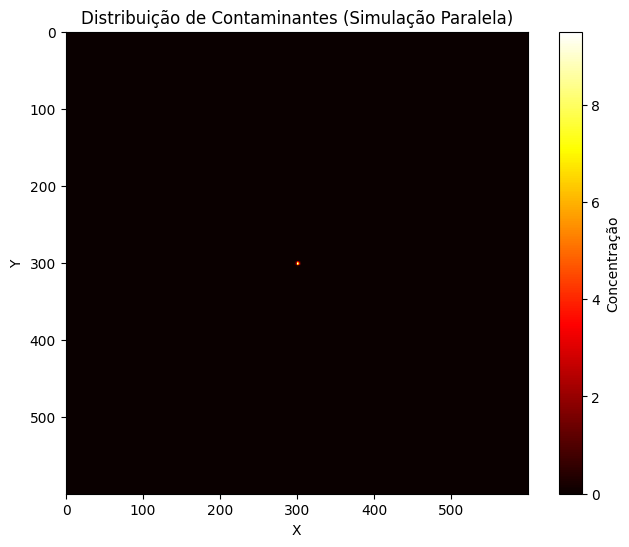

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

data = np.loadtxt('paralelo_output_final.txt')

plt.figure(figsize=(8, 6))
plt.imshow(data, cmap='hot', interpolation='nearest')
plt.colorbar(label='Concentração')
plt.title('Distribuição de Contaminantes (Simulação Paralela)')
plt.xlabel('X')
plt.ylabel('Y')
plt.show()
